In [1]:
from quantopian.pipeline import Pipeline, CustomFactor
from quantopian.research import run_pipeline
from quantopian.pipeline.factors import SimpleMovingAverage,AverageDollarVolume
from quantopian.pipeline.data.builtin import USEquityPricing
import numpy as np

# HOW TO USE THE PIPELINE API

## Initialising a pipeline

In [2]:
pipe = Pipeline()
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
res.head()

Empty DataFrame
Columns: []
Index: [(2016-01-04 00:00:00+00:00, Equity(2 [ARNC])), (2016-01-04 00:00:00+00:00, Equity(21 [AAME])), (2016-01-04 00:00:00+00:00, Equity(24 [AAPL])), (2016-01-04 00:00:00+00:00, Equity(25 [ARNC_PR])), (2016-01-04 00:00:00+00:00, Equity(31 [ABAX]))]

## Building a factor
Factors are numerical values.

In [3]:
sma = SimpleMovingAverage(inputs=[USEquityPricing.close],window_length=10)

## Building a Filter
Filters are boolean values.

In [4]:
adv = AverageDollarVolume(window_length=10)

## Adding factors and filters to pipeline

In [5]:
pipe.add(sma,'sma')
pipe.add(adv,'adv')

In [6]:
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head()

## Adding a screen
This is to screen out any equities that we are not interested in to reduce computation. Here, we see that only a few equities are left in the pipe.

In [7]:
my_screen = AverageDollarVolume(window_length=10)>1e8
pipe = Pipeline(screen=my_screen)
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head(100)

## Adding a mask
Masks reduce the number of equities that are calculated in a factor to save computation. Be sure to also screen out the values that you masked out, otherwise you end up with lots of NaN's.

In [8]:
my_mask = AverageDollarVolume(window_length=10)>1e8
sma = SimpleMovingAverage(inputs=[USEquityPricing.close],window_length=10,mask=my_mask)
my_screen = AverageDollarVolume(window_length=10)>1e8 
pipe = Pipeline(screen=my_screen)
pipe.add(sma,'sma')
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head(100)

## Classifiers
Classifiers are categorical values which can be strings or labels

In [9]:
# This is an example of a label
from quantopian.pipeline.classifiers.morningstar import Sector
sector = Sector()
pipe.add(sector,'sector')
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head(20)

In [10]:
# Here another example of a label
dollar_volume_quantiles = AverageDollarVolume(window_length=10).quantiles(10)
pipe.add(dollar_volume_quantiles,'dollar_volume_quantiles')
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head(20)

## Combined Factors
We can combine built-in factors into new ones

In [11]:
sma10 = SimpleMovingAverage(inputs=[USEquityPricing.close],window_length=10,mask=my_mask)
sma20 = SimpleMovingAverage(inputs=[USEquityPricing.close],window_length=20,mask=my_mask)
sma_ratio = sma20/sma10
pipe.add(sma_ratio,'sma_ratio')
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head()

## Extracting data from the pipe

In [12]:
dates = res.index.get_level_values(0)
dates

DatetimeIndex(['2016-01-04', '2016-01-04', '2016-01-04', '2016-01-04',
               '2016-01-04', '2016-01-04', '2016-01-04', '2016-01-04',
               '2016-01-04', '2016-01-04',
               ...
               '2017-01-03', '2017-01-03', '2017-01-03', '2017-01-03',
               '2017-01-03', '2017-01-03', '2017-01-03', '2017-01-03',
               '2017-01-03', '2017-01-03'],
              dtype='datetime64[ns, UTC]', length=118607, freq=None)

In [13]:
assets = res.index.get_level_values(1)
assets

Index([    Equity(2 [ARNC]),    Equity(24 [AAPL]),     Equity(62 [ABT]),
         Equity(114 [ADBE]),    Equity(128 [ADM]),    Equity(161 [AEP]),
          Equity(168 [AET]),    Equity(216 [HES]),    Equity(239 [AIG]),
         Equity(337 [AMAT]),
       ...
        Equity(45993 [HLT]), Equity(46631 [GOOG]),  Equity(47415 [SYF]),
       Equity(47430 [MBLY]), Equity(47740 [BABA]),  Equity(47777 [CFG]),
        Equity(49229 [KHC]), Equity(49242 [PYPL]),  Equity(49506 [HPE]),
       Equity(50077 [TWLO])],
      dtype='object', length=118607)

In [14]:
res.ix[[(dates[0],assets[0])]]

dollar_volume_quantiles  sector  \
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])                        9     101   

                                               sma  sma_ratio  
2016-01-04 00:00:00+00:00 Equity(2 [ARNC])  9.7505    0.96172

## Custom Factors

In [15]:
from quantopian.pipeline import CustomFactor
from quantopian.pipeline.factors import Returns
class MomentumFactor(CustomFactor):
    window_length = 252
    def compute(self,today,assets,out,close,returns):
        out[:] = ((close[-21] - close[-252])/close[-252] -
                      (close[-1] - close[-21])/close[-21]) / np.nanstd(returns, axis=0)
    

In [16]:
returns = Returns(window_length=126)
momentum = MomentumFactor(inputs=[USEquityPricing.close,returns])
#pipe.remove('momentum')
pipe.add(momentum,'momentum')

In [17]:
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head()

/usr/local/lib/python2.7/dist-packages/numpy/lib/nanfunctions.py:1147: RuntimeWarning: Degrees of freedom <= 0 for slice.
  warnings.warn("Degrees of freedom <= 0 for slice.", RuntimeWarning)


## Data Sets

### Pricing Data
We can see that each column has a type called **dtype**

In [18]:
from quantopian.pipeline.data.builtin import USEquityPricing
USEquityPricing.volume

USEquityPricing.volume::float64

### Fundamental Data
These data are supplied by Morningstar

In [19]:
from quantopian.pipeline.data import morningstar
market_cap = morningstar.valuation.market_cap.latest
#pipe.remove('market_cap')
pipe.add(market_cap,'market_cap')

In [20]:
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head()

### Partner Data

In [21]:
from quantopian.pipeline.data import quandl
#dir(quandl)

In [22]:
vxn = quandl.cboe_vxn.close

In [23]:
sma_vxn = SimpleMovingAverage(window_length=10,inputs=[vxn])

In [24]:
pipe.add(sma_vxn,'sma_vxn')

In [25]:
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head()

## Select Tradeable Stocks

In [26]:
from quantopian.pipeline.filters.morningstar import IsPrimaryShare

# Filter for primary share equities. IsPrimaryShare is a built-in filter.
primary_share = IsPrimaryShare()

In [27]:
# Equities listed as common stock (as opposed to, say, preferred stock).
# 'ST00000001' indicates common stock.
common_stock = morningstar.share_class_reference.security_type.latest.eq('ST00000001')

# Non-depositary receipts. Recall that the ~ operator inverts filters,
# turning Trues into Falses and vice versa
not_depositary = ~morningstar.share_class_reference.is_depositary_receipt.latest

# Equities not trading over-the-counter.
not_otc = ~morningstar.share_class_reference.exchange_id.latest.startswith('OTC')

# Not when-issued equities.
not_wi = ~morningstar.share_class_reference.symbol.latest.endswith('.WI')

# Equities without LP in their name, .matches does a match using a regular
# expression
not_lp_name = ~morningstar.company_reference.standard_name.latest.matches('.* L[. ]?P.?$')

# Equities with a null value in the limited_partnership Morningstar
# fundamental field.
not_lp_balance_sheet = morningstar.balance_sheet.limited_partnership.latest.isnull()

# Equities whose most recent Morningstar market cap is not null have
# fundamental data and therefore are not ETFs.
have_market_cap = morningstar.valuation.market_cap.latest.notnull()

Now we are creating a compound filter that screens out all stocks that are not tradeable.

In [28]:
tradeable_stocks = (
    primary_share
    & common_stock
    & not_depositary
    & not_otc
    & not_wi
    & not_lp_name
    & not_lp_balance_sheet
    & have_market_cap
)
adv_screen = AverageDollarVolume(window_length=10)>1e8
my_screen = adv_screen & tradeable_stocks

In [29]:
pipe = Pipeline(screen=my_screen)
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')
#res.head(100)

# Factor Analysis

In [30]:
import alphalens as al
from quantopian.pipeline.filters import Q1500US

MORNINGSTAR_SECTOR_CODES = {
     -1: 'Misc',
    101: 'Basic Materials',
    102: 'Consumer Cyclical',
    103: 'Financial Services',
    104: 'Real Estate',
    205: 'Consumer Defensive',
    206: 'Healthcare',
    207: 'Utilities',
    308: 'Communication Services',
    309: 'Energy',
    310: 'Industrials',
    311: 'Technology' ,    
}

universe = Q1500US


In [31]:
asset_list = res.index.levels[1].unique()
#asset_list

In [32]:
prices = get_pricing(asset_list, start_date='2016-01-01', end_date='2017-01-01', fields='price')

In [33]:
momentum = MomentumFactor(inputs=[USEquityPricing.close,returns])
pipe.add(momentum,'momentum')

In [34]:
sector = Sector()
pipe.add(sector,'sector')
res = run_pipeline(pipe,'2016-01-01', '2017-01-01')

In [35]:
sectors = res['sector']
my_factor = res['momentum']

In [36]:
        
factor_data = al.utils.get_clean_factor_and_forward_returns(my_factor,
                                                                   prices,
                                                                   quantiles=5,
                                                                   groupby=sectors,
                                                                   groupby_labels=MORNINGSTAR_SECTOR_CODES,
                                                                   periods=(1,5,10,20,30))

Quantiles Statistics


min        max      mean       std  count    count %
factor_quantile                                                            
1               -74.100620  -0.050333 -2.867255  1.774071  14642  20.119823
2                -4.141633   0.899546 -1.025699  0.880033  14514  19.943936
3                -2.824979   1.852223 -0.027580  0.825084  14507  19.934317
4                -1.800273   3.200410  0.988372  0.867814  14514  19.943936
5                -0.597048  15.324658  2.946376  1.452045  14597  20.057988

Returns Analysis


1       5       10       20  \
Ann. alpha                                     0.067  -0.004  -0.014   -0.044   
beta                                          -0.242  -0.269  -0.288   -0.250   
Mean Period Wise Return Top Quantile (bps)    -4.244 -20.635 -44.518  -96.421   
Mean Period Wise Return Bottom Quantile (bps)  4.641  27.639  53.512  126.049   
Mean Period Wise Spread (bps)                 -7.848  -8.501  -8.900  -10.643   

                                                    30  
Ann. alpha                                      -0.061  
beta                                            -0.189  
Mean Period Wise Return Top Quantile (bps)    -134.737  
Mean Period Wise Return Bottom Quantile (bps)  187.240  
Mean Period Wise Spread (bps)                  -10.358

/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:767: FutureWarning: pd.rolling_apply is deprecated for DataFrame and will be removed in a future version, replace with 
	DataFrame.rolling(center=False,min_periods=1,window=5).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:727: FutureWarning: pd.rolling_apply is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(center=False,min_periods=1,window=10).apply(args=<tuple>,func=<function>,kwargs=<dict>)
  min_periods=1, args=(period,))
/usr/local/lib/python2.7/dist-packages/alphalens/pl

Information Analysis


1      5      10     20      30
IC Mean     -0.007 -0.029 -0.044 -0.088  -0.116
IC Std.      0.237  0.241  0.232  0.186   0.154
t-stat(IC)  -0.420 -1.777 -2.839 -7.031 -11.234
p-value(IC)  0.675  0.077  0.005  0.000   0.000
IC Skew      0.196  0.414  0.529  1.004   0.702
IC Kurtosis -0.635 -0.343 -0.521  0.972   0.404
Ann. IR     -0.448 -1.893 -3.024 -7.491 -11.969

/usr/local/lib/python2.7/dist-packages/alphalens/plotting.py:215: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=22,center=False).mean()
  pd.rolling_mean(ic, 22).plot(ax=a,


Turnover Analysis


1      5     10     20     30
Quantile 1 Mean Turnover   0.113  0.283  0.408  0.523  0.549
Quantile 2 Mean Turnover   0.217  0.463  0.598  0.704  0.730
Quantile 3 Mean Turnover   0.236  0.494  0.627  0.723  0.739
Quantile 4 Mean Turnover   0.202  0.441  0.581  0.690  0.709
Quantile 5 Mean Turnover   0.096  0.245  0.348  0.439  0.459

1      5     10     20     30
Mean Factor Rank Autocorrelation  0.986  0.932  0.867  0.743  0.712

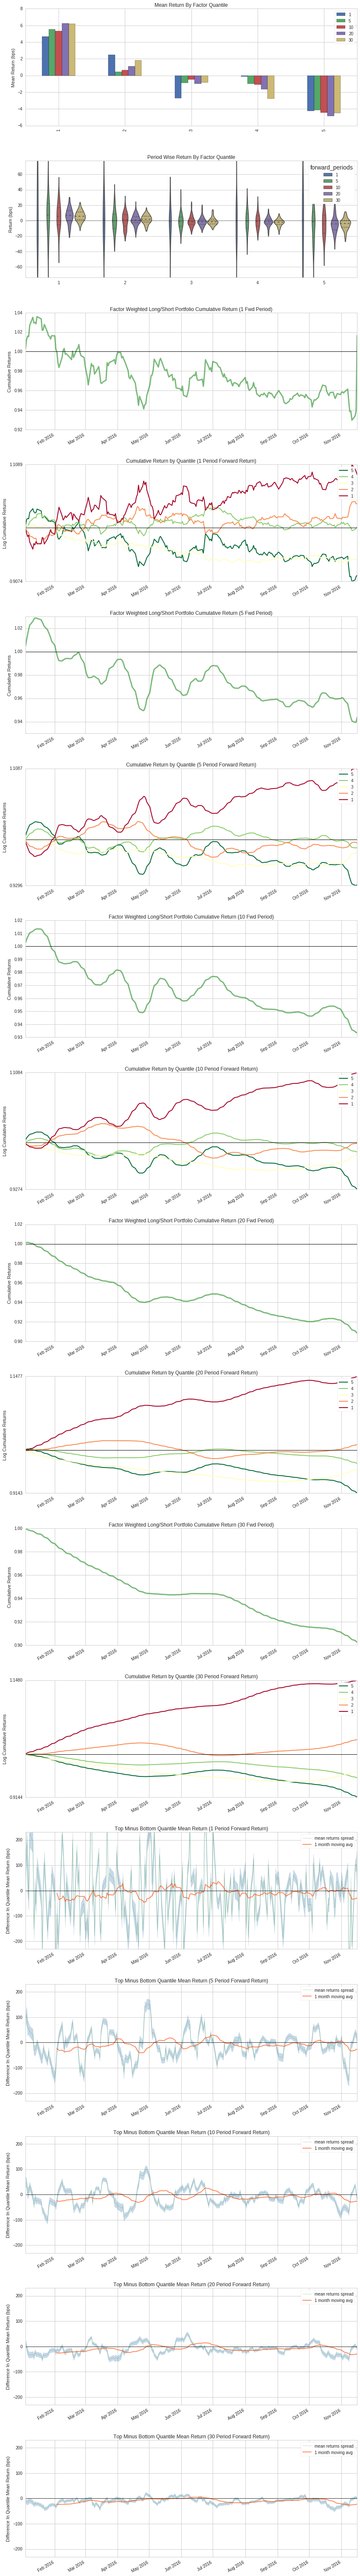

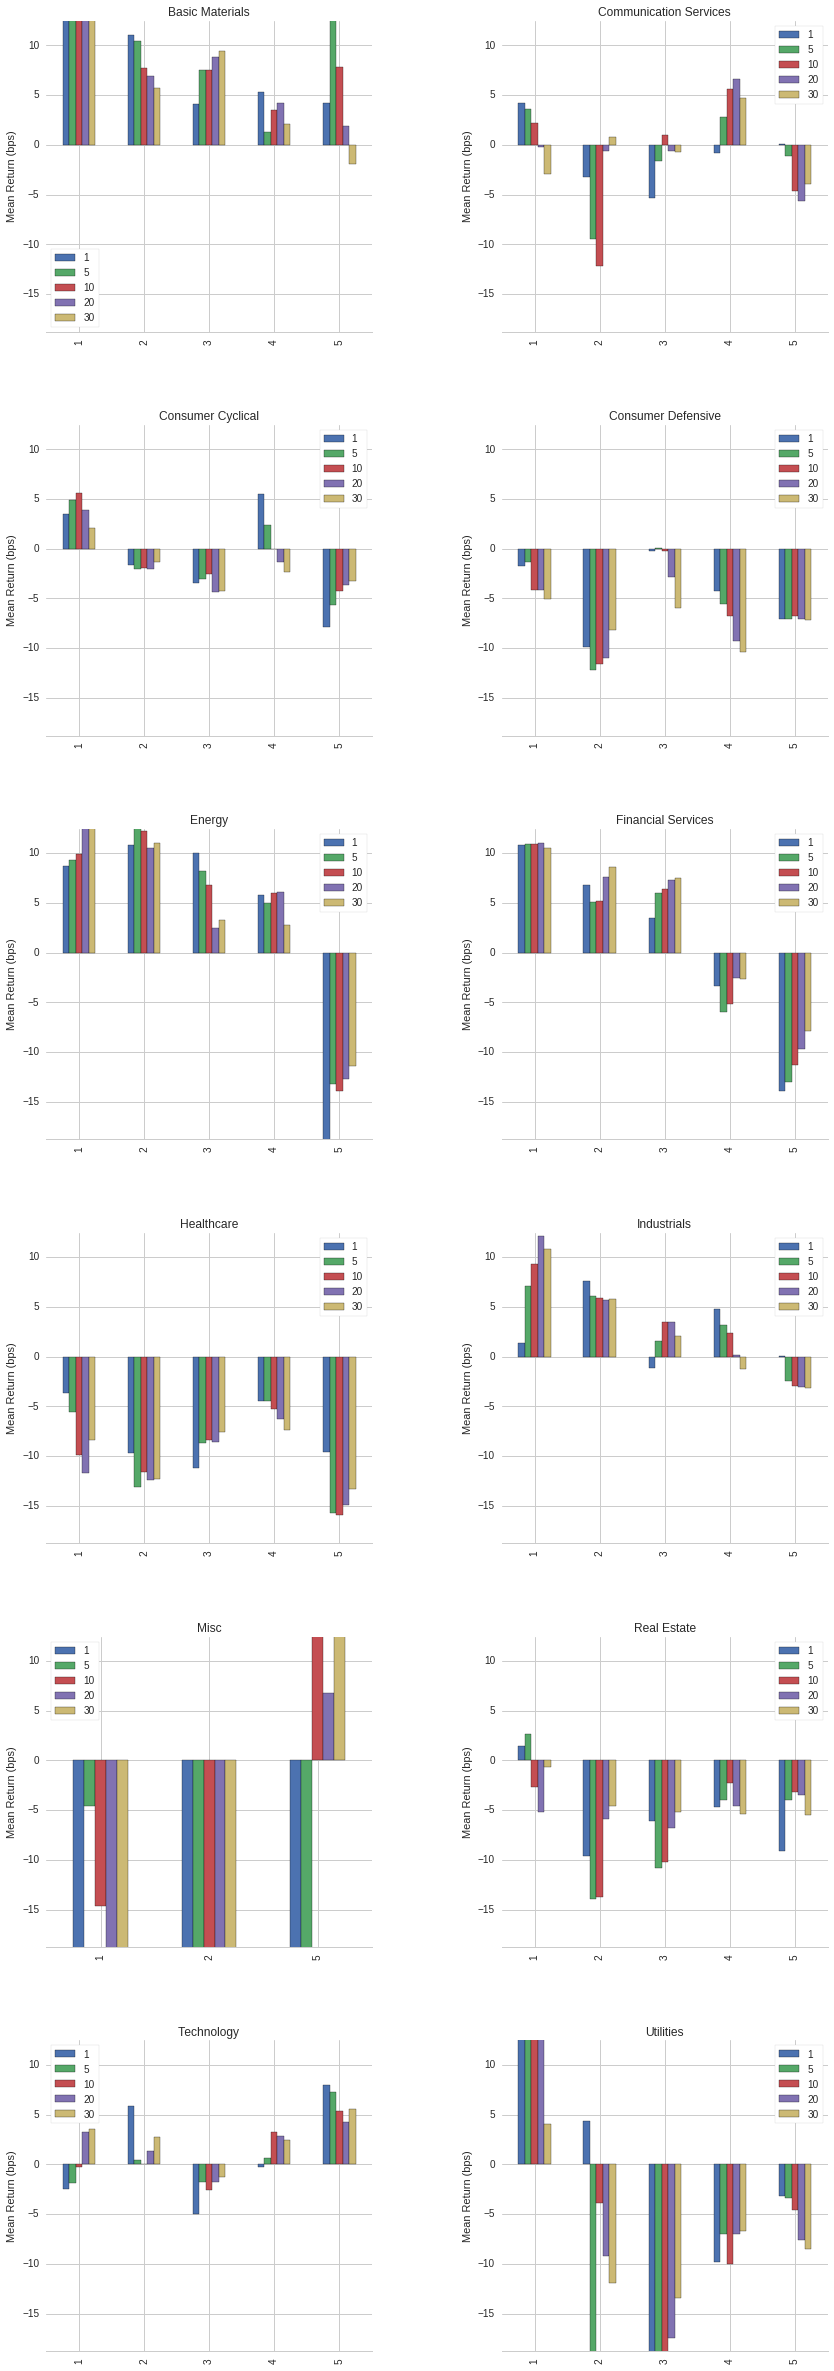

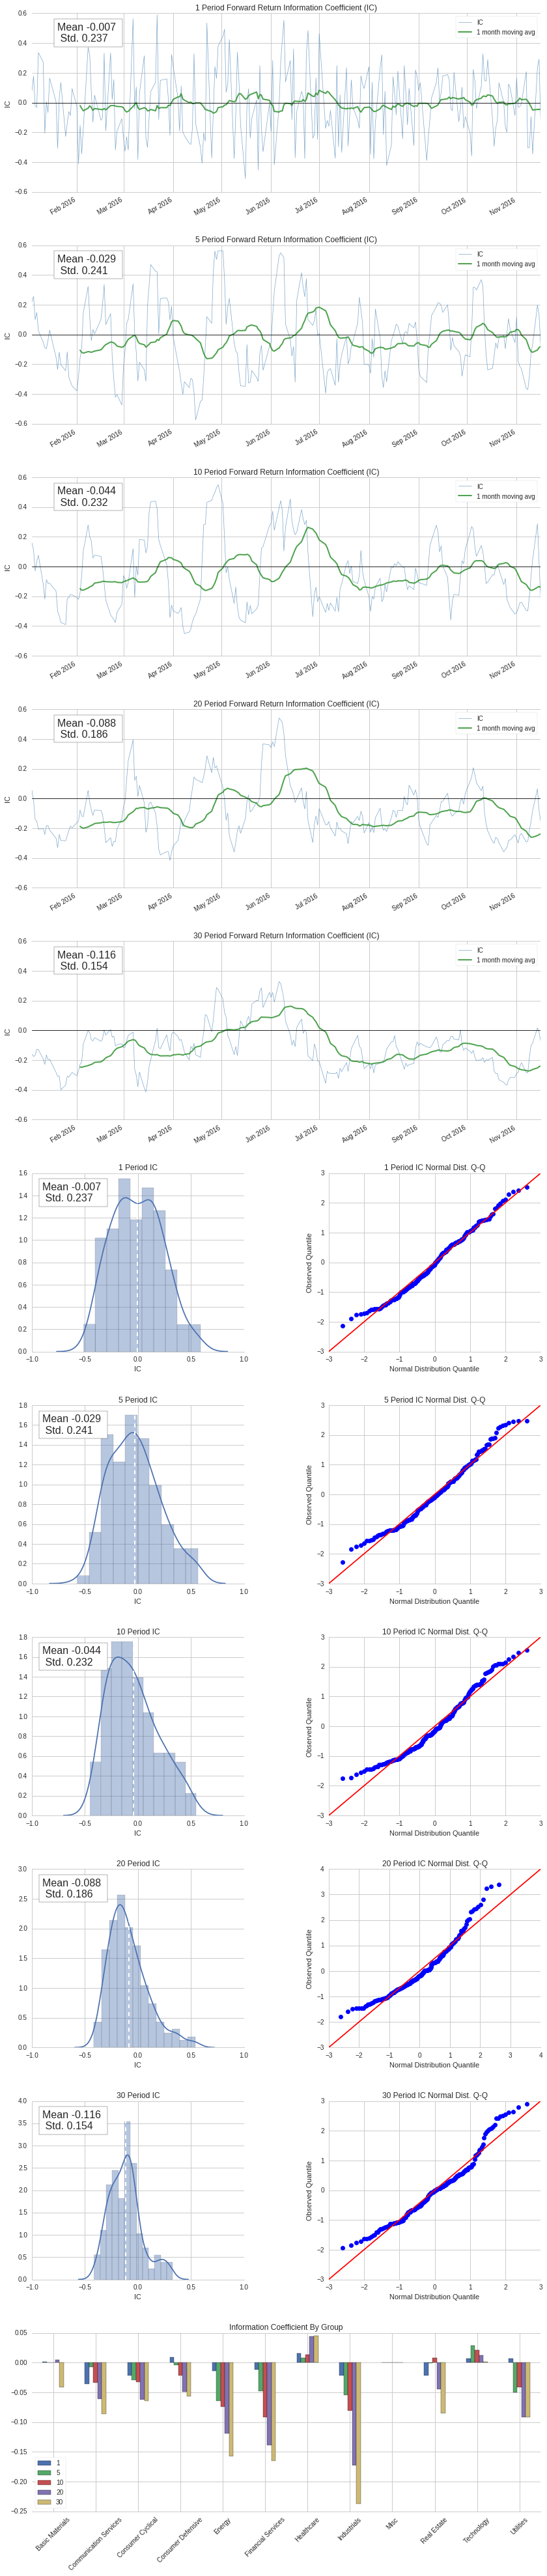

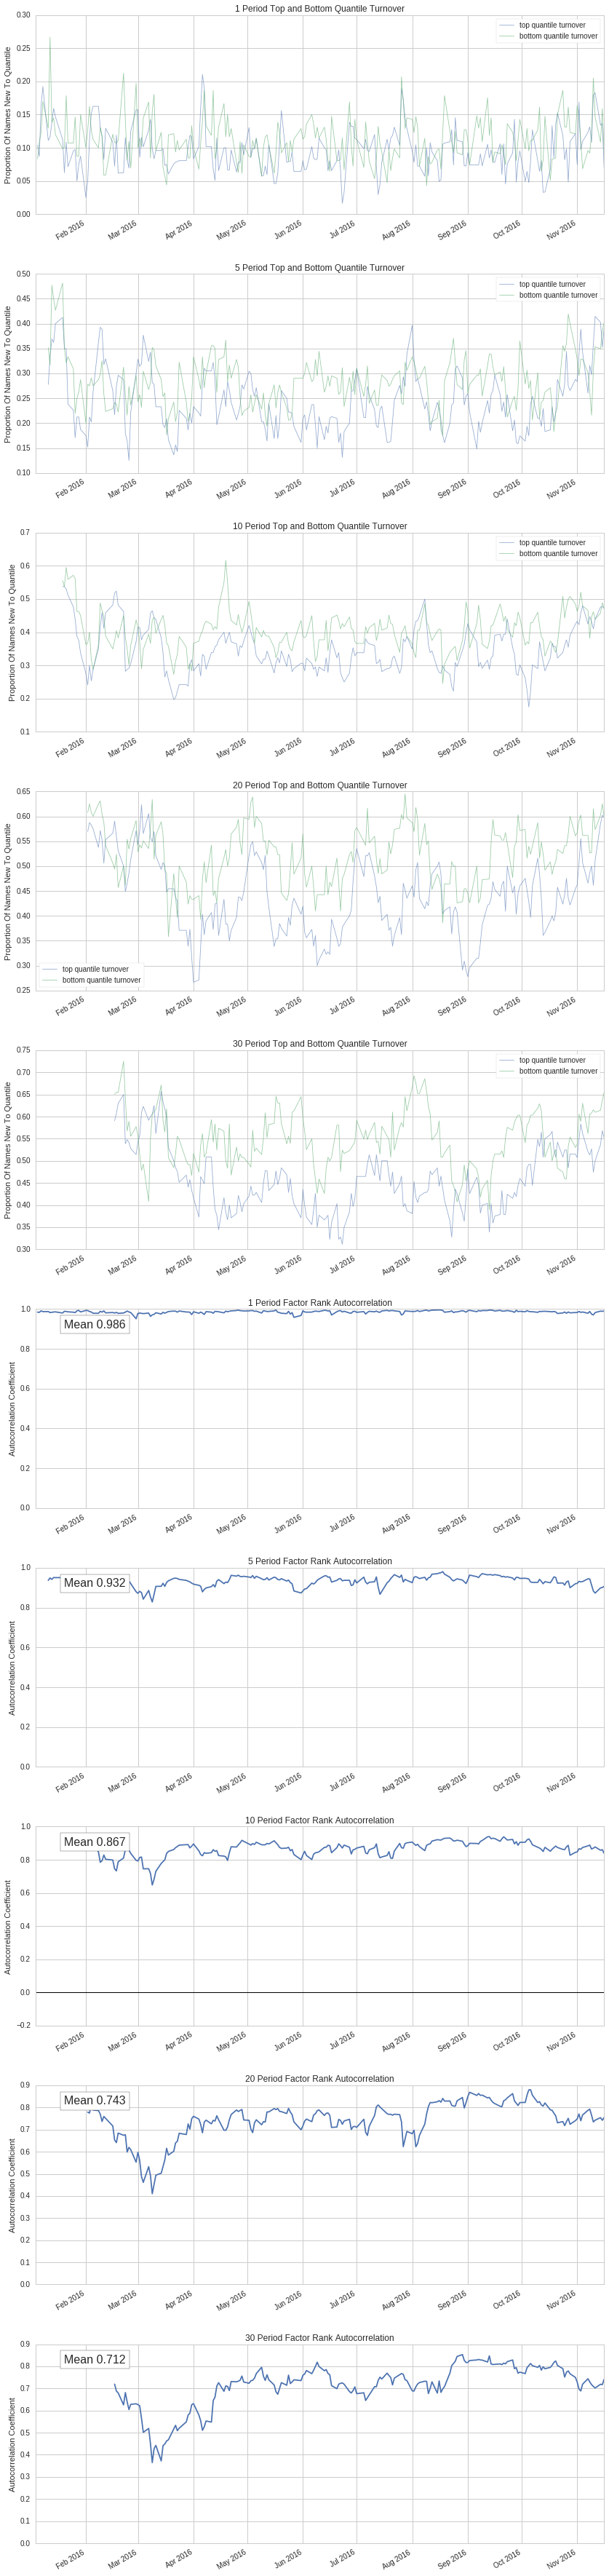

In [37]:
al.tears.create_full_tear_sheet(factor_data,by_group=True)

# Evaluate Your Backtest

After you've run your backtest run the tearsheet. Take the highlighted number from the backtest URL www.quantopian.com/algorithms/59b859606140840bb54e36c1/**59b9b2b30ae68854daf6bf0b**#backtest
and put it into the get_backtest() function. Then run the tearsheet.

100% Time: 0:00:02|###########################################################|
Entire data start date: 2016-01-04
Entire data end date: 2016-12-30


Backtest Months: 12


Performance statistics   Backtest
annual_return                0.09
cum_returns_final            0.09
annual_volatility            0.09
sharpe_ratio                 1.01
calmar_ratio                 1.70
stability_of_timeseries      0.76
max_drawdown                -0.06
omega_ratio                  1.18
sortino_ratio                1.48
skew                        -0.24
kurtosis                     0.80
tail_ratio                   1.07
common_sense_ratio           1.17
gross_leverage               0.99
information_ratio           -0.02
alpha                        0.06
beta                         0.20

Worst drawdown periods net drawdown in %  peak date valley date recovery date  \
0                                   5.54 2016-04-27  2016-06-27    2016-09-08   
1                                   3.77 2016-10-05  2016-11-08           NaT   
2                                   3.62 2016-03-07  2016-04-05    2016-04-19   
3                                   2.54 2016-02-08  2016-02-19    2016-03-03   
4                                   2.13 2016-01-06  2016-01-20    2016-01-29   

Worst drawdown periods duration  
0                            97  
1                           NaN  
2                            32  
3                            19  
4                            18



[-0.011 -0.023]


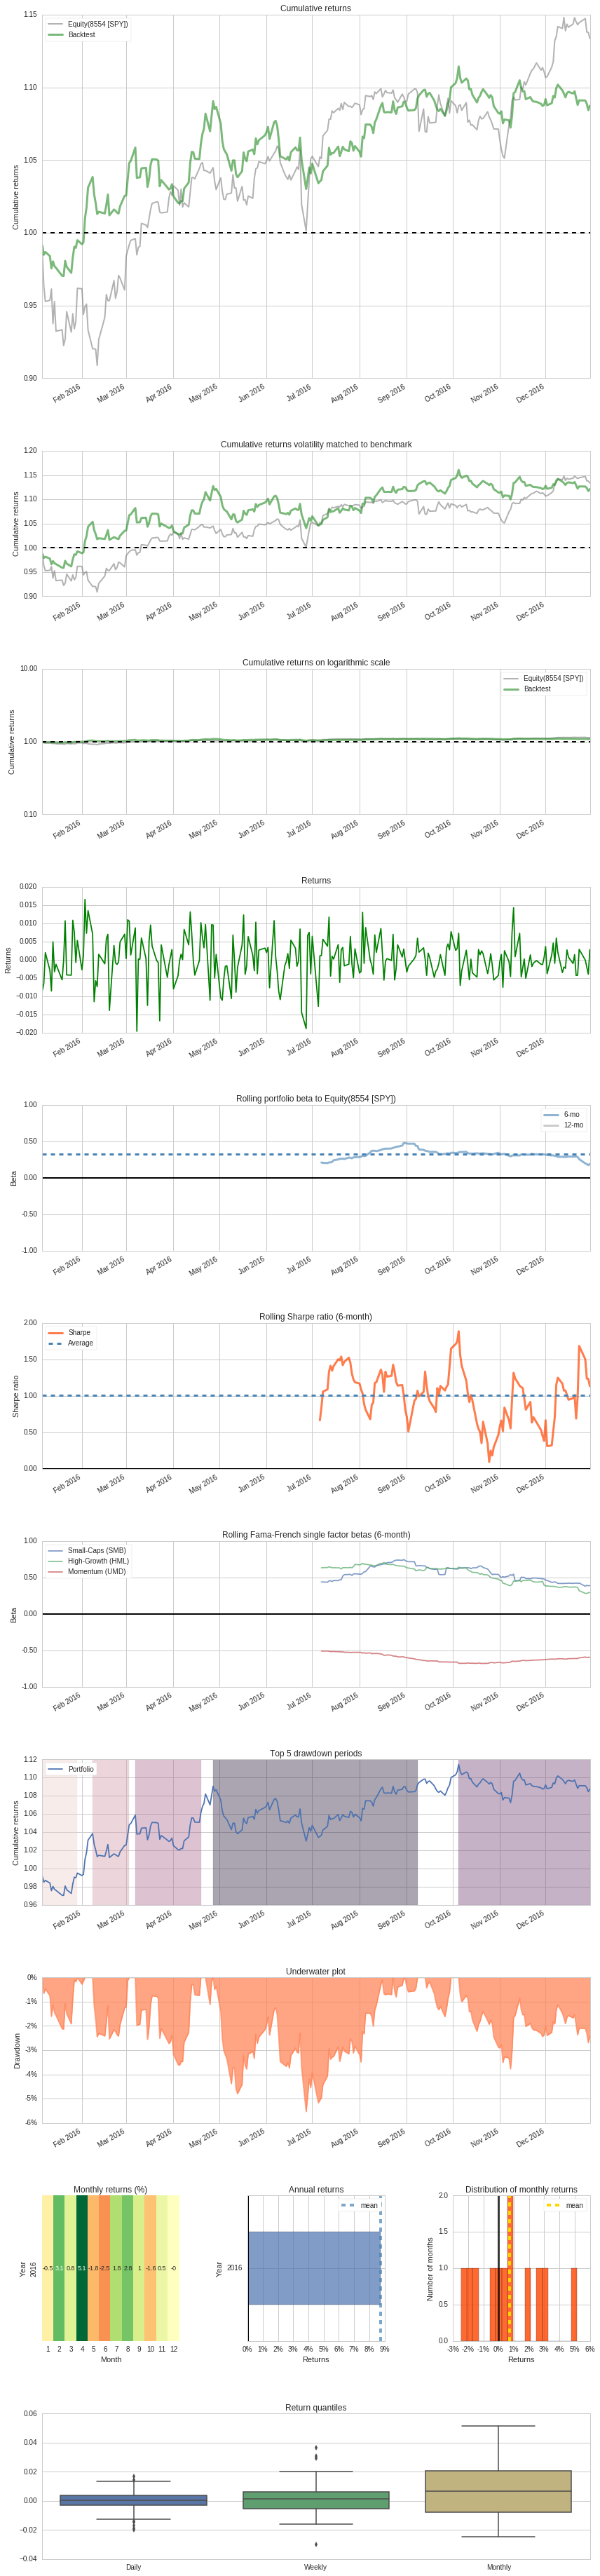

Stress Events  mean    min   max
New Normal    0.04% -1.97% 1.66%

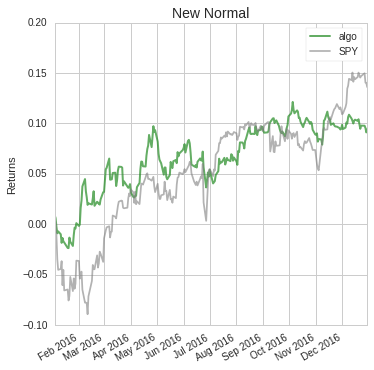

Top 10 long positions of all time   max
EXAS-22364                        0.64%
X-8329                            0.63%
RLYP-45851                        0.62%
SM-4664                           0.58%
NAV-5199                          0.56%
PBYI-42689                        0.55%
CLVS-42166                        0.55%
SWN-7244                          0.54%
MKTO-44738                        0.54%
CXW-22102                         0.53%

Top 10 short positions of all time    max
CPXX-45390                         -0.67%
AKS-10897                          -0.59%
CLF-1595                           -0.58%
X-8329                             -0.57%
EXEL-21383                         -0.52%
SRPT-16999                         -0.52%
ARIA-11880                         -0.51%
PRTA-43730                         -0.50%
CDE-1374                           -0.49%
UNT-7806                           -0.47%

Top 10 positions of all time   max
CPXX-45390                   0.67%
EXAS-22364                   0.64%
X-8329                       0.63%
RLYP-45851                   0.62%
AKS-10897                    0.59%
SM-4664                      0.58%
CLF-1595                     0.58%
NAV-5199                     0.56%
PBYI-42689                   0.55%
CLVS-42166                   0.55%

All positions ever held   max
CPXX-45390              0.67%
EXAS-22364              0.64%
X-8329                  0.63%
RLYP-45851              0.62%
AKS-10897               0.59%
SM-4664                 0.58%
CLF-1595                0.58%
NAV-5199                0.56%
PBYI-42689              0.55%
CLVS-42166              0.55%
SWN-7244                0.54%
MKTO-44738              0.54%
CXW-22102               0.53%
NE-5249                 0.52%
EXEL-21383              0.52%
ONCE-48547              0.52%
OAS-39797               0.52%
SRPT-16999              0.52%
ARIA-11880              0.51%
WLL-25707               0.51%
TLRD-7203               0.51%
CVI-22766               0.51%
LPI-42263               0.51%
HLX-17180               0.50%
BLUE-44935              0.50%
PRTA-43730              0.50%
SAGE-47332              0.49%
LNKD-41451              0.49%
RGLD-6455               0.49%
CDE-1374                0.49%
...                       ...
AGNC-36243              0.33%
ZEN-46918               0.33%
ATRA-47901              0.33%
WWD-16425               0.33%
XRX-8354                0.33%
HD-3496                 0.33%
PANW-43202              0.33%
WM-19181                0.33%
CSOD-41098              0.33%
MCHP-8677               0.33%
KERX-21789              0.33%
DG-38936                0.33%
HURN-26708              0.33%
DHI-2298                0.33%
SERV-47207              0.33%
CIT-39053               0.33%
VG-32143                0.33%
NOW-43127               0.33%
PTCT-44955              0.33%
TNK-35260               0.33%
TILE-3832               0.33%
PRE-10025               0.33%
ICUI-3796               0.33%
HELE-3522               0.33%
UHAL-12141              0.32%
HQY-47397               0.32%
OIS-22464               0.32%
HP-3647                 0.28%
T-6653                  0.19%
WOOF-23267              0.01%

[1061 rows x 1 columns]

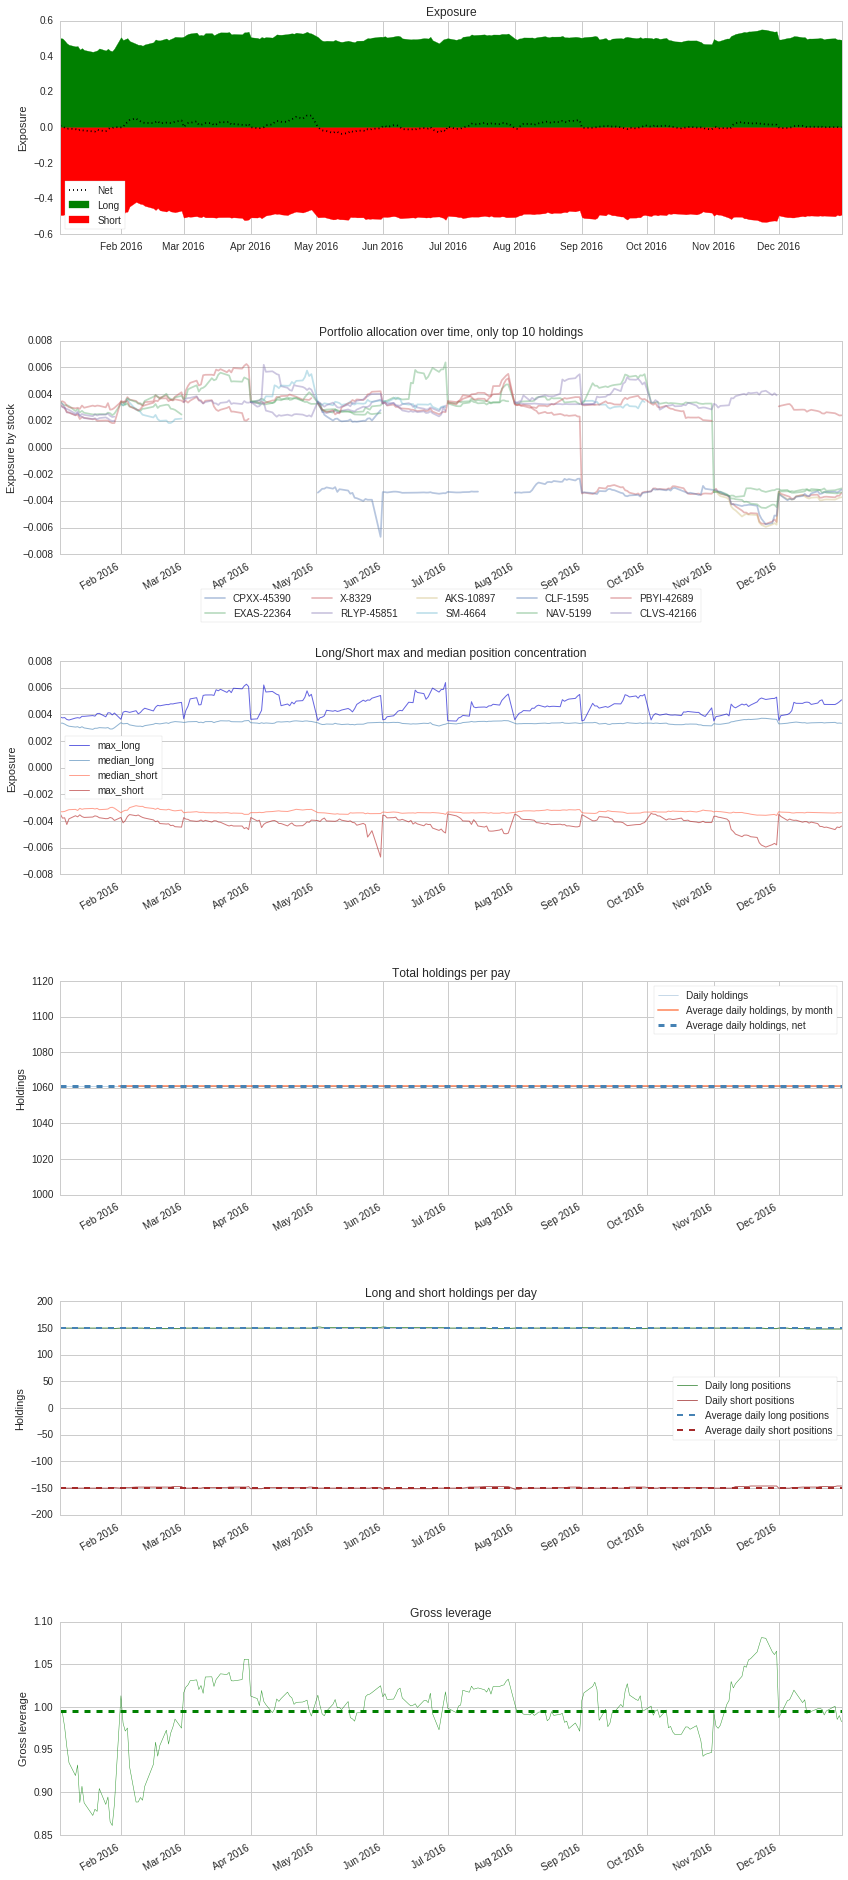

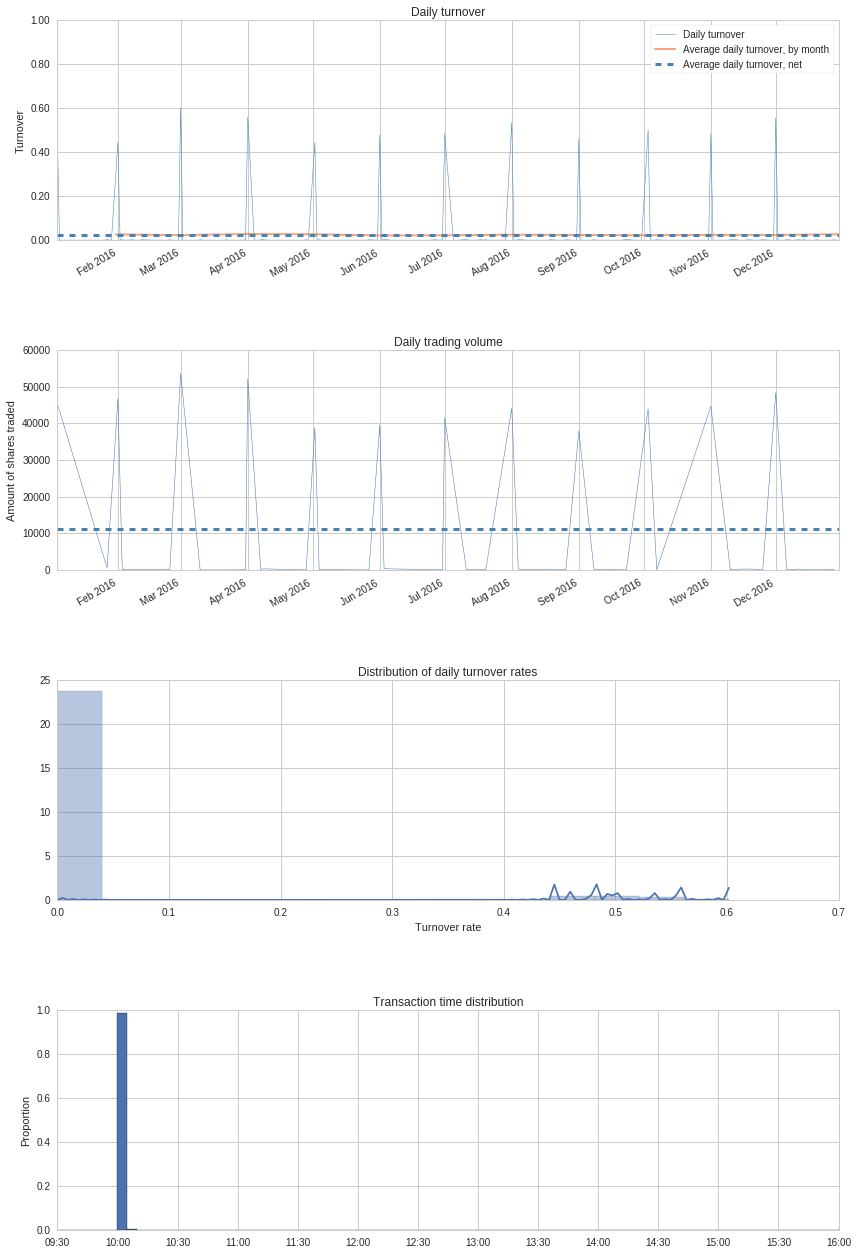

In [40]:
bt =get_backtest('59b9b2b30ae68854daf6bf0b')
bt.create_full_tear_sheet()